Using TensorFlow backend.
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.6/site-packages/ipykernel_launcher.py:139: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), activation="relu", strides=(2, 2))`
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.6/site-packages/ipykernel_launcher.py:140: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="relu", strides=(2, 2))`
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.6/site-packages/ipykernel_launcher.py:141: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="relu", strides=(2, 2))`
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.6/site-packages/ipykernel_launcher.py:142: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.6/site-packages/ipykernel_launcher.py:143: UserWarning: Update your `Conv2D` call to the Keras 2 API: `

Epoch 1/3
1856/1856 [==============================] - 632s - loss: 0.0025 - val_loss: 0.0021
Epoch 2/3
1856/1856 [==============================] - 623s - loss: 7.8375e-04 - val_loss: 0.0029
Epoch 3/3
1856/1856 [==============================] - 625s - loss: 6.4439e-04 - val_loss: 0.0018
Model saved at: model_track1_forward_backward_ForwardSlow_patches.h5


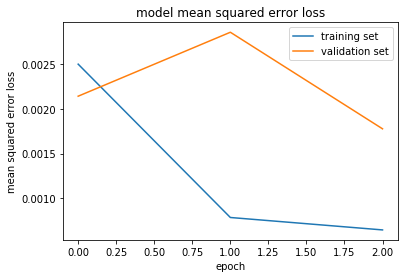

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.6/site-packages/ipykernel_launcher.py:155: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=<generator..., steps_per_epoch=1645, epochs=3, validation_steps=412)`


Epoch 1/3
1645/1645 [==============================] - 549s - loss: 0.0010 - val_loss: 0.0027
Epoch 2/3
1645/1645 [==============================] - 548s - loss: 3.2810e-04 - val_loss: 0.0026
Epoch 3/3
  39/1645 [..............................] - ETA: 473s - loss: 4.5682e-04

In [ ]:
import csv
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pickle
from keras.layers.convolutional import Cropping2D
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from keras.models import load_model


######################################################################################################
class MacOSFile(object):
    def __init__(self, f):
        self.f = f

    def __getattr__(self, item):
        return getattr(self.f, item)

    def read(self, n):
        # print("reading total_bytes=%s" % n, flush=True)
        if n >= (1 << 31):
            buffer = bytearray(n)
            idx = 0
            while idx < n:
                batch_size = min(n - idx, 1 << 31 - 1)
                # print("reading bytes [%s,%s)..." % (idx, idx + batch_size), end="", flush=True)
                buffer[idx:idx + batch_size] = self.f.read(batch_size)
                # print("done.", flush=True)
                idx += batch_size
            return buffer
        return self.f.read(n)

    def write(self, buffer):
        n = len(buffer)
        print("writing total_bytes=%s..." % n, flush=True)
        idx = 0
        while idx < n:
            batch_size = min(n - idx, 1 << 31 - 1)
            print("writing bytes [%s, %s)... " % (idx, idx + batch_size), end="", flush=True)
            self.f.write(buffer[idx:idx + batch_size])
            print("done.", flush=True)
            idx += batch_size

def pickle_dump(obj, file_path):
    with open(file_path, "wb") as f:
        return pickle.dump(obj, MacOSFile(f), protocol=pickle.HIGHEST_PROTOCOL)

def pickle_load(file_path):
    with open(file_path, "rb") as f:
        return pickle.load(MacOSFile(f))
#################
# pickle_dump(data, "data.p")
# data = pickle_load("data.p")
# 
# print('Data creation/loading completed...')
######################################################################################################
 
            
def generate_data(lines, train_dir, batch_size=32):
    num_lines = len(lines)
    while 1: # Loop forever so the generator never terminates
        shuffle(lines)
        #batch_pbar = tqdm(range(0, num_lines, batch_size), unit='batches')
        for offset in range(0, num_lines, batch_size):
            batch_lines = lines[offset:offset+batch_size]
            
            data = {'front_images': [], 'left_images': [], 'right_images': [], 
                'steering_angles_front': [], 'steering_angles_left': [], 'steering_angles_right': []}
            
            for line in batch_lines:
                front_filename = line[0].split('/')[-1]
                left_filename = line[1].split('/')[-1]
                right_filename = line[2].split('/')[-1]
                 
                #TODO: Tune this parameter, try 0.25
                steering_correction = 0.25
                  
                #TODO: Consider randomly dropping low (<0.05 abs) steering angles to reduce bias
                # With augmentation (flipped and steering_angle reversed)
                IMG_DIR = './data/training/' + 'ALL_IMGS/'
                
                front_image = cv2.imread(IMG_DIR + front_filename)
                steering_angle = np.float(line[3])
                data['front_images'].append(front_image)
                data['front_images'].append(cv2.flip(front_image, 1))
                data['steering_angles_front'].append(steering_angle)
                data['steering_angles_front'].append(-1.0 * steering_angle)
                 
                left_image = cv2.imread(IMG_DIR + left_filename)
                steering_angle_left = np.float(line[3]) + steering_correction
                data['left_images'].append(left_image)
                data['left_images'].append(cv2.flip(left_image, 1))
                data['steering_angles_left'].append(steering_angle_left)
                data['steering_angles_left'].append(-1.0 * steering_angle_left)
                 
                right_image = cv2.imread(IMG_DIR + right_filename)
                steering_angle_right = np.float(line[3]) - steering_correction
                data['right_images'].append(right_image)
                data['right_images'].append(cv2.flip(right_image, 1))
                data['steering_angles_right'].append(steering_angle_right)
                data['steering_angles_right'].append(-1.0 * steering_angle_right)
            X_train = np.array(data['front_images'] + data['left_images'] + data['right_images'])
            y_train = np.array(data['steering_angles_front'] + data['steering_angles_left'] + data['steering_angles_right'])
            yield shuffle(X_train, y_train)

def get_train_validation_generator(train_dir):
    lines = []
    with open(train_dir + 'driving_log.csv') as csvFile:
        reader = csv.reader(csvFile)
        for line in reader:
            #TODO: This was my little hack after I messed up the CSVs
            lines.append(line[0].split(',')) 
            
    #lines = lines[:5]                  
    train_lines, validation_lines = train_test_split(lines, test_size=0.2)
    train_data_generator = generate_data(train_lines, train_dir)
    validation_data_generator = generate_data(validation_lines, train_dir)
    return (train_data_generator, validation_data_generator, train_lines, validation_lines)

datasets = ['track1_forward', 'track1_forward_backward', \
            'track1_forward_backward_ForwardSlow', 'track1_forward_backward_ForwardSlow_forwardCorrectional', \
            'track1_forward_backward_ForwardSlow_patches']
data = {}
for filename in datasets:
    data[filename] = get_train_validation_generator('./data/training/' + filename + '/')
    
# Model
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D
from keras.layers import Convolution2D
from keras.layers.pooling import MaxPooling2D

def train_model(existing_model_filename, data, output_model_filename):
    if not existing_model_filename:
        model = Sequential()
        # Normalized data with zero mean
        model.add(Lambda(lambda x:x/255.0 - 0.5, input_shape=(160, 320, 3)))
        model.add(Cropping2D(cropping=((70,25), (0,0))))
        model.add(Convolution2D(24,5,5, subsample=(2,2), activation='relu'))
        model.add(Convolution2D(36,5,5, subsample=(2,2), activation='relu'))
        model.add(Convolution2D(48,5,5, subsample=(2,2), activation='relu'))
        model.add(Convolution2D(64,3,3,activation='relu'))
        model.add(Convolution2D(64,3,3,activation='relu'))
        model.add(Flatten())
        model.add(Dense(100))
        model.add(Dense(50))
        model.add(Dense(10))
        model.add(Dense(1))
        
        model.compile(optimizer='adam', loss='mse')
    else:
        model = load_model(existing_model_filename)
    
    #model.fit(np.array(X_train), np.array(y_train), validation_split=0.2, shuffle=True, nb_epoch=3)
    history_object = model.fit_generator(data[0], samples_per_epoch= \
                        len(data[2]), validation_data=data[1], \
                        nb_val_samples=len(data[3]), nb_epoch=3)
    model.save(output_model_filename)
    print('Model saved at: ' + output_model_filename)
    # Visualize
    ### plot the training and validation loss for each epoch
    plt.plot(history_object.history['loss'])
    plt.plot(history_object.history['val_loss'])
    plt.title('model mean squared error loss')
    plt.ylabel('mean squared error loss')
    plt.xlabel('epoch')
    plt.legend(['training set', 'validation set'], loc='upper right')
    plt.show()
    
    return model

for i in range(len(datasets)):
    filename = datasets[i]
#     track_1_model = train_model(None if i==0 else 'model_' + datasets[i-1] + '.h5', \
#                                 data[filename], \
#                                 'model_' + filename + '.h5')
    track_1_patch = train_model(None if i==0 else 'model_' + 'track1_forward_backward_ForwardSlow' + '.h5', \
                                data[filename], \
                                'model_' + 'track1_forward_backward_ForwardSlow_patches' + '.h5')